In [182]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import os
import sys
os.chdir('../')
sys.path.append('./')
os.getcwd()
from model import DeepJSCC
import matplotlib.pyplot as plt
import matplotlib
from utils import get_psnr, image_normalization

### Eval para

In [183]:
channel = 'AWGN'
saved = r'C:\Users\Utente\Desktop\Fast Github Repos\Deep-JSCC-PyTorch\out\checkpoints\CIFAR10_8_1.0_0.17_AWGN_18h07m57s_on_Mar_28_2025\epoch_999.pkl'

snr = 20
test_image_dir = r'C:\Users\Utente\Desktop\Fast Github Repos\Deep-JSCC-PyTorch\demo\kodim23.png'
times = 10

In [184]:
transform = transforms.Compose([transforms.ToTensor()])
test_image = Image.open(test_image_dir)
test_image.load()
test_image = transform(test_image)

### Trans from nn.DataParallel to nn.Module

In [185]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [186]:
state_dict = torch.load(saved, map_location=torch.device('cpu'))
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.','') # remove `module.`
    new_state_dict[name] = v
# model.load_state_dict(torch.load(saved))

C:\Users\Utente\AppData\Local\Temp\ipykernel_7528\3659090198.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(saved, map_location=torch.device('cp

### Load model from checkpoint

In [187]:
file_name = os.path.basename(os.path.dirname(saved))
c = file_name.split('_')[1]
c = int(c)
model = DeepJSCC(c=c, channel_type=channel, snr=snr)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(new_state_dict)
model.change_channel(channel, snr)

### Eval for times

In [188]:
test_image.shape

torch.Size([3, 512, 768])

average psnr is 27.427896118164064 for 10 times on kodim23.png


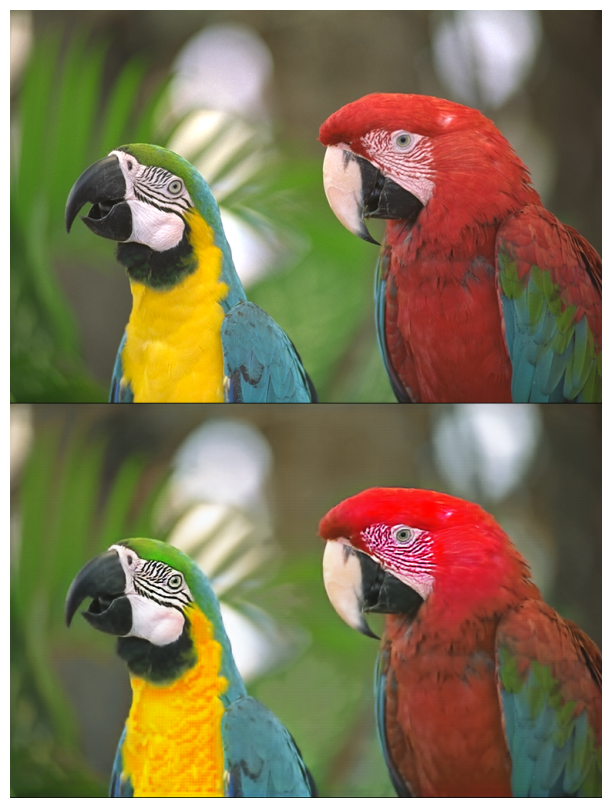

In [189]:
psnr_all = 0.0
with torch.no_grad():

    for i in range(times):
        demo_image = model(test_image)
        demo_image = image_normalization('denormalization')(demo_image)
        gt = image_normalization('denormalization')(test_image)
        psnr_all += get_psnr(demo_image, gt)
    demo_image = image_normalization('normalization')(demo_image)
    demo_image = torch.cat([test_image, demo_image.squeeze()], dim=1)
    demo_image = demo_image.numpy()

dpi = 100
height, width = demo_image.shape[1], demo_image.shape[2]
figsize = (width / dpi, height / dpi)

fig = plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(demo_image.transpose(1, 2, 0))
plt.axis('off')

print("average psnr is {} for {} times on {}".format( psnr_all.item() / times, times, os.path.basename(test_image_dir)))